## Step 1: Load your data, including testing/training split from Project 1.

In [136]:
# Initial code copied from Project 1
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("oasis_longitudinal.csv")

# First, drop NaN value rows on the non-split data to keep it balanced for the split
# Drop rows with null/missing values in SES and MMSE columns (identified by using data.info())
data = data.dropna(axis=0)

# Define the predictor and the feature set
X = data.drop('Group', axis=1)
y = data['Group']

# Finally, divide into training and test sets, add random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Code copied from Project 1

# Get rid of unecessary features: handedness (since all are right handed), MR delay time, Subject ID, MRI ID, Visit number
X_train = X_train.drop(['Hand', 'MR Delay', 'Subject ID', 'MRI ID', 'Visit'], axis=1)
X_test = X_test.drop(['Hand', 'MR Delay', 'Subject ID', 'MRI ID', 'Visit'], axis=1)

# Convert "M/F" categorical attribute to int. F is class '0' and M is class '1'.
X_train['M/F'].replace(['M', 'F'], [0, 1], inplace=True)
X_test['M/F'].replace(['M', 'F'], [0, 1], inplace=True)

# Since we are interested in predicting dementia based on biological attributes, not conversion to it, 
# transform "Converted" predictor category to "Demented."
y_train = y_train.str.replace('Converted', 'Demented')
y_test = y_test.str.replace('Converted', 'Demented')

# Encode the categorical predictor "Demented" to class '0' vs "Nondemented" to class '1'.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Feature scaling. Decided to use StandardScaler instead of MinMaxScaler so that 
# the mean was 0 and standard deviation constant i.e. create Gaussian data.
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

## Step 2: PCA for feature selection

In [137]:
from sklearn.decomposition import PCA

# Perform PCA on scaled training data, explore it.
pca = PCA()
pca.fit(X_train_scaled)

print('---PCA on scaled data---')
print('Number of components: {}'.format(pca.n_components_))
print('Explained variance ratio of each feature: {}'.format(pca.explained_variance_ratio_))

# Use sklearn PCA's built-in function that performs PCA on the number of components explained by a stated 
# variance 0<x<1 (in this case, 0.95, or 95%). Then fit_transform the data.
pca95 = PCA(n_components=0.95)
pca95.fit(X_train_scaled)
print('\n---PCA on scaled data with 95% variance---')
print('Number of features retaining 95% of the variance: {}'.format(pca95.n_components_))

# Use 95% PCA transformed X training data and apply to Logistic Regression (with best parameters [default] from Project 2).
# There is no improvment - the scoring metrics remain the same.
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
pca95_X_train = pca95.transform(X_train_scaled)
logreg.fit(pca95_X_train, y_train)
# Remember to apply PCA to the (scaled) test data too (but don't re-fit it).
pca95_X_test = pca95.transform(X_test_scaled)
y_pred = logreg.predict(pca95_X_test)
print('\n\n Logistic Regression with PCA\n' + classification_report(y_test, y_pred))

# Use 95% PCA transformed X training data and apply to the Decision Tree Classifier (with best parameters from Project 2).
# Here I excluded max_features=8, since this threw up an error because 8 was higher than the number of dimensions of the PCA
# transformed dataset.
from sklearn.tree import DecisionTreeClassifier
dectree_best = DecisionTreeClassifier(criterion = 'entropy', max_depth=5, random_state=2)
dectree_best.fit(pca95_X_train, y_train)
y_pred2 = dectree_best.predict(pca95_X_test)

# Print classification report. This PCA processing actually lowers the scores for the Decision Tree Classifier.
from sklearn.metrics import classification_report
print('\n\n Decision Tree with PCA\n' + classification_report(y_test, y_pred2))

---PCA on scaled data---
Number of components: 9
Explained variance ratio of each feature: [0.31884031 0.23268029 0.1550938  0.14193459 0.05346675 0.03850638
 0.03018848 0.02822425 0.00106515]

---PCA on scaled data with 95% variance---
Number of features retaining 95% of the variance: 7


 Logistic Regression with PCA
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        33
           1       0.93      1.00      0.96        38

    accuracy                           0.96        71
   macro avg       0.96      0.95      0.96        71
weighted avg       0.96      0.96      0.96        71



 Decision Tree with PCA
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.87      0.89      0.88        38

    accuracy                           0.87        71
   macro avg       0.87      0.87      0.87        71
weighted avg       0.87      0.87      0.87        71


## Step 3: Apply 3-types of clustering on your data and visualize the output of each both with and without PCA run on it first. Calculate both ARI and Silhouette Coefficient for all six of the combinations.

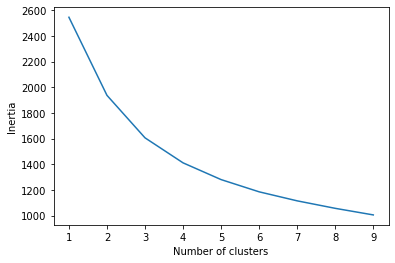

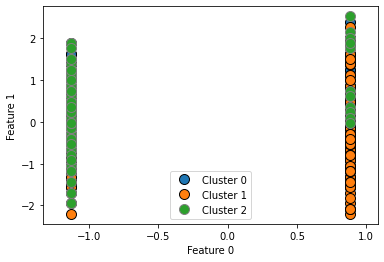

Adjusted rand score: 0.16137198391417043
Silhouette score: 0.24660145582362006


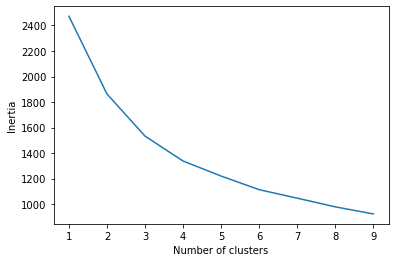

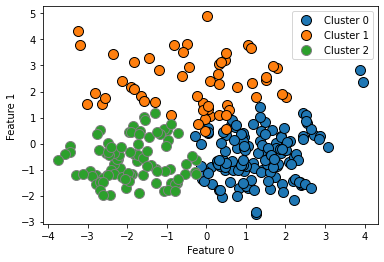

Adjusted rand score: 0.15235632793779363
Silhouette score: 0.2541916483190182


In [138]:
# Kmeans
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import mglearn
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import silhouette_score


# First run with the non-PCA transformed data. Create a dictionary, run through the typical 1-9 k cluster number for 
# kmeans algorithm and add inertia values to dictionary, then plot.
inertiaVals = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(X_train_scaled)
    inertiaVals[k] = kmeans.inertia_

plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

# Visualize two features in non-PCA transformed using mglearn. Tried n_clusters = 4, based on elbow plot, but this gave
# a bad ARI and silhouette score. Changed to n_clusters = 3.
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_scaled)
mglearn.discrete_scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], kmeans.labels_, markers='o')
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

# Calculate ARI and silhouette coefficient.
print("Adjusted rand score: {}".format(adjusted_rand_score(y_train, kmeans.fit_predict(X_train_scaled))))
print("Silhouette score: {}".format(silhouette_score(X_train_scaled, kmeans.fit_predict(X_train_scaled))))


# Run with the PCA transformed training data. No change in elbow plot except inertia scaling is reduced.
inertiaVals2 = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(pca95_X_train)
    inertiaVals2[k] = kmeans.inertia_

plt.figure()
plt.plot(list(inertiaVals2.keys()), list(inertiaVals2.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

# Visualize two features in PCA transformed data using mglearn. Use n_clusters = 4, based on elbow plot.
kmeans = KMeans(n_clusters=3)
kmeans.fit(pca95_X_train)
mglearn.discrete_scatter(pca95_X_train[:, 0], pca95_X_train[:, 1], kmeans.labels_, markers='o')
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

# Calculate ARI and silhouette coefficient.
print("Adjusted rand score: {}".format(adjusted_rand_score(y_train, kmeans.fit_predict(pca95_X_train))))
print("Silhouette score: {}".format(silhouette_score(pca95_X_train, kmeans.fit_predict(pca95_X_train))))

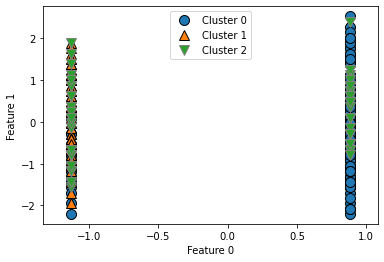

Adjusted rand score: 0.21005852233918407
Silhouette score: 0.2291207384839351


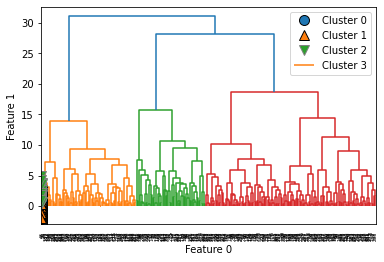

Adjusted rand score: 0.09429353626326831
Silhouette score: 0.23792956704455848


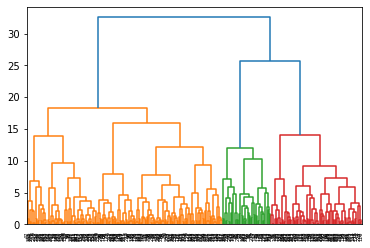

In [139]:
#Agglommerate/Hierarichical
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward

# Run with 4 clusters per the previous KMeans elbow. Running with 3 clusters improves ARI and Silhouette to 0.21 and 0.229,
# respectively.
agg = AgglomerativeClustering(n_clusters=3)

# First, non-PCA transformed
agglomClust = agg.fit_predict(X_train_scaled)

mglearn.discrete_scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], agglomClust)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

# Apply the ward clustering to the data array X_train_scaled
# The SciPy ward function returns an array that specifies the distances bridged when performing agglomerative clustering.
linkage_array = ward(X_train_scaled)
# Now we plot the dendrogram for the linkage_array containing the distances between clusters. Note this is a relatively
# qualitative view.
dendrogram(linkage_array);

# Calculate ARI and silhouette coefficient.
print("Adjusted rand score: {}".format(adjusted_rand_score(y_train, agglomClust)))
print("Silhouette score: {}".format(silhouette_score(X_train_scaled, agglomClust)))


# Next, PCA transformed
agglomClust = agg.fit_predict(pca95_X_train)

mglearn.discrete_scatter(pca95_X_train[:, 0], pca95_X_train[:, 1], agglomClust)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

linkage_array = ward(pca95_X_train)
dendrogram(linkage_array);

# Calculate ARI and silhouette coefficient.
print("Adjusted rand score: {}".format(adjusted_rand_score(y_train, agglomClust)))
print("Silhouette score: {}".format(silhouette_score(pca95_X_train, agglomClust)))

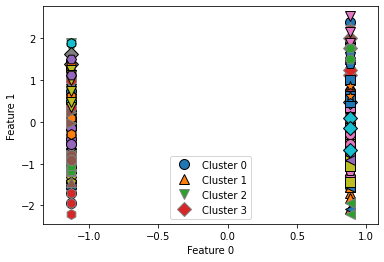

Adjusted rand score: 0.14380000240958923
Silhouette score: 0.12394249337378326


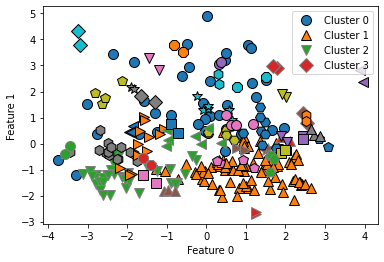

Adjusted rand score: 0.15970121812282848
Silhouette score: 0.11309762757921511


In [141]:
# DBSCAN on non-PCA transformed data
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(min_samples=2, eps=1.3)
clusters = dbscan.fit_predict(X_train_scaled)

mglearn.discrete_scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

# Calculate ARI and silhouette coefficient.
print("Adjusted rand score: {}".format(adjusted_rand_score(y_train, clusters)))
print("Silhouette score: {}".format(silhouette_score(X_train_scaled, clusters)))


# PCA transformed
clusters = dbscan.fit_predict(pca95_X_train)

mglearn.discrete_scatter(pca95_X_train[:, 0], pca95_X_train[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

# Calculate ARI and silhouette coefficient.
print("Adjusted rand score: {}".format(adjusted_rand_score(y_train, clusters)))
print("Silhouette score: {}".format(silhouette_score(pca95_X_train, clusters)))